In [ ]:
# hide
# skip
! [ -e /content ] && pip install -Uqq model_inspector
# For colab. Restart the runtime after running this cell!

In [ ]:
# default_exp inspect

# inspect

> Inspect models.

In [ ]:
# hide
from nbdev.showdoc import *

In [ ]:
# export
# Meant to be colorblind-friendly
COLORS = {"blue": "#377eb8", "orange": "#ff7f00", "green": "#4daf4a", "pink": "#f781bf"}

In [ ]:
# export
from enum import auto, Enum
from typing import Callable, Iterable, Optional, Sequence, Union
import warnings

from IPython.display import HTML
from matplotlib.axes import Axes
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.base import ClassifierMixin, clone, RegressorMixin
import sklearn.datasets
from sklearn.linear_model._base import LinearModel, LinearClassifierMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.validation import check_is_fitted
import waterfall_chart

from model_inspector.explore import plot_correlation
from model_inspector.tune import calculate_metrics_by_thresh

In [ ]:
# export
def get_inspector(model, X, y):
    """Get an appropriate inspector for your model and data

    Parameters:
    - `model`: Fitted sklearn model
    - `X`: Feature matrix with same shape and column meanings as
    features `model` was trained on
    - `y`: Target series with same length as `X` and same meaning as
    target `model` was trained on
    """
    model_type = identify_type(model, y)
    if isinstance(model, LinearModel):
        result = _LinRegInspector(model, X, y)
    elif isinstance(model, LinearClassifierMixin):
        result = (
            _LinBinInspector(model, X, y)
            if model_type == ModelType.BINARY
            else _LinMultiInspector(model, X, y)
        )
    elif model_type in [ModelType.BINARY, ModelType.MULTICLASS]:
        result = _ClasInspector(model, X, y)
    else:
        result = _RegInspector(model, X, y)
    return result

In [ ]:
# hide
# export
class ModelType(Enum):
    REGRESSION = auto()
    BINARY = auto()
    MULTICLASS = auto()

In [ ]:
# hide
# export
def identify_type(model, y):
    if isinstance(model, RegressorMixin):
        result = ModelType.REGRESSION
    elif isinstance(model, ClassifierMixin):
        if len(y.unique()) == 2:
            result = ModelType.BINARY
        else:
            result = ModelType.MULTICLASS
    else:
        raise NotImplementedError("Model type not recognized")
    return result

In [ ]:
# export
def _custom_dir(c, add):
    return set(sorted(dir(type(c)) + list(c.__dict__.keys()) + add))


class _GetAttr:
    "Base class for attr accesses in `self._xtra` passed down to `self.default`"

    @property
    def _xtra(self):
        return [o for o in dir(self.default) if not o.startswith("_")]

    def __getattr__(self, k):
        if k in self._xtra:
            return getattr(self.default, k)
        raise AttributeError(k)

    def __dir__(self):
        return _custom_dir(self, self._xtra)

In [ ]:
# export
class _Inspector(_GetAttr):
    def __init__(self, model, X, y):
        check_is_fitted(model)
        self.model, self.X, self.y = model, X, y
        self.plotter = self._get_plotter_class()(self.model, self.X, self.y)
        self.default = self.plotter

    def _get_plotter_class(self):
        result = _Plotter
        num_features = len(self.X.columns)
        model_type = identify_type(self.model, self.y)
        if model_type is ModelType.REGRESSION:
            if num_features == 1:
                result = _1dPlotter
            elif num_features == 2:
                result = _Reg2dPlotter
        elif model_type is ModelType.BINARY:
            if num_features == 1:
                result = _Bin1dPlotter
            elif num_features == 2:
                result = _Bin2dPlotter
        else:
            if num_features == 1:
                result = _1dPlotter
            elif num_features == 2:
                result = _Multi2dPlotter
        return result

In [ ]:
# export
class _ClasInspector(_Inspector):
    def calculate_metrics_by_thresh(
        self,
        prob_to_pred: Union[str, Callable],
        metrics: Union[Callable, Sequence[Callable]],
    ) -> pd.DataFrame:
        """Calculate classification metrics as a function of threshold

        Parameters:
        - `prob_to_pred`: Callable that takes
        `self.model.predict_proba(self.X)` and `thresh` as positional
        arguments and returns `y_pred`
        - `metrics`: Callables that take `self.y`, `y_pred` as
        positional arguments and return a number. Must have a `__name__`
        attribute.

        Returns: DataFrame with one column "thresh" indicating the
        thresholds used, which is 0 and the sorted set of values that
        occur in `y_prob`, and an additional column for each input
        metric giving the value of that metric at that threshold.
        """
        return calculate_metrics_by_thresh(
            y_true=self.y,
            y_prob=self.model.predict_proba(self.X),
            prob_to_pred=prob_to_pred,
            metrics=metrics,
        )

In [ ]:
# export
class _RegInspector(_Inspector):
    def plot_pred_vs_act(
        self,
        ax: Optional[Axes] = None,
        scatter_kwargs: Optional[dict] = None,
        line_kwargs: Optional[dict] = None,
    ) -> Axes:
        """Plot predicted vs. actual values

        Parameters:
        - `ax`: Matplotlib `Axes` object. Plot will be added to this object
        if provided; otherwise a new `Axes` object will be generated.
        - `scatter_kwargs`: kwargs to pass to `plt.scatter`
        - `line_kwargs`: kwargs to pass to `plt.plot`
        """
        if ax is None:
            _, ax = plt.subplots()

        if scatter_kwargs is None:
            scatter_kwargs = {}
        if "alpha" not in scatter_kwargs:
            scatter_kwargs["alpha"] = 0.3
        y_pred = self.model.predict(self.X)
        ax.scatter(self.y, y_pred, **scatter_kwargs)

        if line_kwargs is None:
            line_kwargs = {}
        if "label" not in line_kwargs:
            line_kwargs["label"] = "predicted=actual"
        ax.plot(
            [self.y.min(), self.y.max()],
            [y_pred.min(), y_pred.max()],
            **line_kwargs,
        )

        ax.set(xlabel="Actual", ylabel="Predicted")
        ax.legend()
        return ax

    def plot_residuals(
        self,
        ax: Optional[Axes] = None,
        scatter_kwargs: Optional[dict] = None,
        line_kwargs: Optional[dict] = None,
    ) -> Axes:
        """Plot residuals

        Parameters:
        - `ax`: Matplotlib `Axes` object. Plot will be added to this object
        if provided; otherwise a new `Axes` object will be generated.
        - `scatter_kwargs`: kwargs to pass to `plt.scatter`
        - `line_kwargs`: kwargs to pass to `plt.plot` for line at y=0
        """
        if ax is None:
            _, ax = plt.subplots()

        if scatter_kwargs is None:
            scatter_kwargs = {}
        if "alpha" not in scatter_kwargs:
            scatter_kwargs["alpha"] = 0.3
        ax.scatter(
            x=self.y.index, y=self.y - self.model.predict(self.X), **scatter_kwargs
        )

        if line_kwargs is None:
            line_kwargs = {}
        if "linestyle" not in line_kwargs:
            line_kwargs["linestyle"] = "dashed"
        ax.plot([self.y.index.min(), self.y.index.max()], [0, 0], **line_kwargs)
        return ax

In [ ]:
# hide
# export
def generate_model_html(
    intercept: float,
    coefs: Sequence[float],
    feature_names: Iterable[str],
    target_name: str,
    intercept_formatter: str = ".2f",
    coef_formatter: str = ".2f",
):
    if len(coefs) != len(feature_names):
        raise ValueError("len(coefs) != len(feature_cols)")
    model_string = f"""
        <span style='color:{COLORS["pink"]}'>{target_name}</span>
        = <span style='color:{COLORS["orange"]}'>{intercept:{intercept_formatter}}</span>
    """
    for coef, feature_col in zip(coefs, feature_names):
        model_string += f"""
            <span style='color:{COLORS["green"]}'>{"+" if coef >= 0 else "-"} {abs(coef):{coef_formatter}}</span>
            * <span style='color:{COLORS["blue"]}'>{feature_col}</span>
        """
    return model_string

In [ ]:
# export
class _LinRegInspector(_RegInspector):
    """Linear regression model inspector"""

    def plot_coefs_vs_hparam(self, hparam: str, vals: Sequence[float]):
        """Plot coefficient values against a hyperparameter

        Parameters:
        - `hparam`: Name of hyperparameter; must be an attribute of
        `self.model`
        - `vals`: Values of that hyperparameter to use
        """
        current_val = getattr(self.model, hparam)
        model = clone(self.model)
        setattr(model, hparam, vals[-1])
        model.fit(self.X, self.y)
        column_order = model.coef_.argsort()[::-1]
        X = self.X.iloc[:, column_order]

        coefs = []
        for val in vals:
            setattr(model, hparam, val)
            coefs.append(model.fit(X, self.y).coef_)

        fig, ax = plt.subplots()
        ax.plot(vals, coefs)
        ax.axvline(current_val, c="k", label="current value")
        ax.set(xlabel=hparam, ylabel="coefficient value")
        ax.legend(X.columns, bbox_to_anchor=(1.05, 1.0), loc="upper left")
        return ax

    def plot_waterfall(
        self,
        item: Union[pd.Series, np.array],
        bar_num_formatter: str = ".1f",
        tick_num_formatter: str = ".2f",
        sorted_value=True,
        threshold=0.01,
        blue_color=COLORS["blue"],
        green_color=COLORS["green"],
        red_color=COLORS["orange"],
        **waterfall_kwargs,
    ):
        """Make a waterfall chart showing how each feature contributes
        to the prediction for the input item.

        Parameters:
        - `item`: Input item, with the same shape and value meanings as
        a single row from `self.X`
        - `bar_num_formatter`: Bar label format specifier
        - `tick_num_formatter`: Tick label format specifier

        Additional keyword arguments will be passed to
        `waterfall_chart.plot`
        """
        return _plot_waterfall(
            X=self.X,
            y=self.y,
            item=item,
            intercept=self.model.intercept_,
            coefs=self.model.coef_,
            y_lab="Contribution to prediction",
            bar_num_formatter=bar_num_formatter,
            tick_num_formatter=tick_num_formatter,
            sorted_value=sorted_value,
            threshold=threshold,
            blue_color=blue_color,
            green_color=green_color,
            red_color=red_color,
            **waterfall_kwargs,
        )

    def show_equation(
        self,
        intercept_formatter: str = ".2f",
        coef_formatter: str = ".2f",
    ):
        """Show model equation

        Parameters:
        - `intercept_formatter`: Intercept format specifier
        - `coef_formatter`: Intercept format specifier
        """
        return HTML(
            generate_model_html(
                intercept=self.model.intercept_,
                coefs=self.model.coef_,
                feature_names=self.X.columns,
                target_name=self.y.name,
                intercept_formatter=intercept_formatter,
                coef_formatter=coef_formatter,
            )
        )

In [ ]:
# export
def _plot_waterfall(
    X,
    y,
    item: Union[pd.Series, np.array],
    intercept: float,
    coefs: Sequence[float],
    y_lab="",
    bar_num_formatter: str = ".1f",
    tick_num_formatter: str = ".2f",
    sorted_value=True,
    threshold=0.01,
    blue_color=COLORS["blue"],
    green_color=COLORS["green"],
    red_color=COLORS["orange"],
    **waterfall_kwargs,
):
    index = ["int"] + [
        f"{name}: {val:{tick_num_formatter}}" for name, val in zip(X.columns, item)
    ]
    vals = [intercept] + list(np.array(coefs) * item)
    waterfall_chart.plot(
        index=index,
        data=vals,
        x_lab="Feature name and value",
        y_lab=y_lab,
        formatting=f"{{:,{bar_num_formatter}}}",
        net_label=y.name,
        sorted_value=sorted_value,
        threshold=threshold,
        blue_color=blue_color,
        green_color=green_color,
        red_color=red_color,
        **waterfall_kwargs,
    )
    return plt.gca()

In [ ]:
# export
class _LinBinInspector(_ClasInspector):
    """Linear binary classification model inspector"""

    def plot_coefs_vs_hparam(self, hparam: str, vals: Sequence[float]) -> np.array:
        """Plot coefficient values against a hyperparameter

        Parameters:
        - `hparam`: Name of hyperparameter; must be an attribute of
        `self.model`
        - `vals`: Values of that hyperparameter to use
        """
        current_val = getattr(self.model, hparam)
        model = clone(self.model)
        setattr(model, hparam, vals[-1])
        column_order = model.fit(self.X, self.y).coef_[0].argsort()[::-1]
        X = self.X.iloc[:, column_order]

        coef_arrays = []
        for val in vals:
            setattr(model, hparam, val)
            coef_arrays.append(model.fit(self.X, self.y).coef_)

        num_target_vals = len(set(self.y))
        if num_target_vals == 2:
            fig, ax = plt.subplots()
            ax.plot(vals, [coefs[0] for coefs in coef_arrays])
            axes = np.array(ax)[None]
        else:
            fig, axes = plt.subplots(
                num_target_vals, 1, sharex=True, sharey=True, constrained_layout=True
            )
            for target_val_num in range(num_target_vals):
                axes[target_val_num].plot(
                    vals, [coefs[target_val_num] for coefs in coef_arrays]
                )
                axes[target_val_num].set_title(
                    f"y={sorted(set(self.y))[target_val_num]}"
                )
        axes[0].set(xlabel=hparam, ylabel="Coefficient Value")
        for ax in axes:
            ax.axvline(current_val, c="k", label="current value")
        axes[0].legend(X.columns, bbox_to_anchor=(1.05, 1.0), loc="upper left")
        return axes

    def show_equation(
        self,
        intercept_formatter: str = ".2f",
        coef_formatter: str = ".2f",
    ):
        """Show model equation

        Parameters:
        - `intercept_formatter`: Intercept format specifier
        - `coef_formatter`: Intercept format specifier
        """
        return HTML(
            generate_model_html(
                intercept=self.model.intercept_[0],
                coefs=self.model.coef_[0],
                feature_names=self.X.columns,
                target_name=f"log-odds({self.y.name})",
                intercept_formatter=intercept_formatter,
                coef_formatter=coef_formatter,
            )
        )

    def plot_waterfall(
        self,
        item: Union[pd.Series, np.array],
        bar_num_formatter: str = ".1f",
        tick_num_formatter: str = ".2f",
        sorted_value=True,
        threshold=0.01,
        blue_color=COLORS["blue"],
        green_color=COLORS["green"],
        red_color=COLORS["orange"],
        **waterfall_kwargs,
    ):
        """Make a waterfall chart showing how each feature contributes
        to the prediction for the input item for a binary classification
        model.

        Parameters:
        - `item`: Input item, with the same shape and value meanings as
        a single row from `self.X`
        - `bar_num_formatter`: Bar label format specifier
        - `tick_num_formatter`: Tick label format specifier
        - ``waterfall_kwargs`: kwargs to pass to `waterfall_chart.plot`
        """
        return _plot_waterfall(
            X=self.X,
            y=self.y,
            item=item,
            intercept=self.model.intercept_[0],
            coefs=self.model.coef_[0],
            y_lab="Contribution to predicted log-odds",
            bar_num_formatter=bar_num_formatter,
            tick_num_formatter=tick_num_formatter,
            sorted_value=sorted_value,
            threshold=threshold,
            blue_color=blue_color,
            green_color=green_color,
            red_color=red_color,
            **waterfall_kwargs,
        )

In [ ]:
# export
class _LinMultiInspector(_ClasInspector):
    """Linear multiclass classification model inspector"""

    def plot_coefs_vs_hparam(self, hparam: str, vals: Sequence[float]) -> np.array:
        """Plot coefficient values against a hyperparameter

        Parameters:
        - `hparam`: Name of hyperparameter; must be an attribute of
        `self.model`
        - `vals`: Values of that hyperparameter to use
        """
        current_val = getattr(self.model, hparam)
        model = clone(self.model)
        setattr(model, hparam, vals[-1])
        column_order = model.fit(self.X, self.y).coef_[0].argsort()[::-1]
        X = self.X.iloc[:, column_order]

        coef_arrays = []
        for val in vals:
            setattr(model, hparam, val)
            coef_arrays.append(model.fit(self.X, self.y).coef_)

        num_target_vals = len(set(self.y))
        if num_target_vals == 2:
            fig, ax = plt.subplots()
            ax.plot(vals, [coefs[0] for coefs in coef_arrays])
            axes = np.array(ax)[None]
        else:
            fig, axes = plt.subplots(
                num_target_vals, 1, sharex=True, sharey=True, constrained_layout=True
            )
            for target_val_num in range(num_target_vals):
                axes[target_val_num].plot(
                    vals, [coefs[target_val_num] for coefs in coef_arrays]
                )
                axes[target_val_num].set_title(
                    f"y={sorted(set(self.y))[target_val_num]}"
                )
        axes[0].set(xlabel=hparam, ylabel="Coefficient Value")
        for ax in axes:
            ax.axvline(current_val, c="k", label="current value")
        axes[0].legend(X.columns, bbox_to_anchor=(1.05, 1.0), loc="upper left")
        return axes

    def show_equation(
        self,
        intercept_formatter: str = ".2f",
        coef_formatter: str = ".2f",
    ):
        """Show model equation

        Parameters:
        - `intercept_formatter`: Intercept format specifier
        - `coef_formatter`: Intercept format specifier
        """
        model_string = ""
        for target_name, coefs, intercept in zip(
            self.y.unique(), self.model.coef_, self.model.intercept_
        ):
            model_string += f"""
                    <p>
                        {generate_model_html(
                                intercept=intercept,
                                coefs=coefs,
                                feature_names=self.X.columns,
                                target_name=f"log-odds({self.y.name} = {target_name})",
                                intercept_formatter=intercept_formatter,
                                coef_formatter=coef_formatter,
                            )
                        }
                    </p>
                """
        return HTML(model_string)

In [ ]:
# export
class _Plotter:
    def __init__(self, model, X, y):
        self.model, self.X, self.y = model, X, y

    def plot_correlation(self, ax: Optional[Axes] = None, **heatmap_kwargs) -> Axes:
        """Plot a correlation matrix for `self.X` and `self.y`

        Parameters:
        - `ax`: Matplotlib `Axes` object. Plot will be added to this object
        if provided; otherwise a new `Axes` object will be generated.
        - `heatmap_kwargs`: kwargs to pass to `sns.heatmap`
        """
        return plot_correlation(
            pd.concat((self.X, self.y), axis="columns"),
            ax=ax,
            **heatmap_kwargs,
        )

In [ ]:
# export
class _1dPlotter(_Plotter):
    def plot(
        self,
        plot_data: bool = True,
        line_kwargs: Optional[dict] = None,
        scatter_kwargs: Optional[dict] = None,
        ax: Optional[Axes] = None,
    ) -> Axes:
        """Plot predictions from a regression or multiclass model with a
        single input as a line

        Parameters:
        - `plot_data`: Make a scatter plot of the data
        - `line_kwargs`: kwargs to pass to `ax.plot` for plotting
        predictions
        - `scatter_kwargs`: kwargs to pass to `ax.scatter` for plotting data
        - `ax`: Matplotlib `Axes` object. Plot will be added to this object
        if provided; otherwise a new `Axes` object will be generated.
        """

        def _plot_preds(ax):
            X_sorted = self.X.sort_values(self.X.columns[0])
            ax.plot(
                X_sorted.iloc[:, 0],
                self.model.predict(X_sorted),
                label="predictions",
                **line_kwargs,
            )
            return ax

        if line_kwargs is None:
            line_kwargs = {}
        if scatter_kwargs is None:
            scatter_kwargs = {"alpha": 0.4}
        if ax is None:
            _, ax = plt.subplots()
        if plot_data:
            ax.scatter(self.X.iloc[:, 0], self.y, **scatter_kwargs)
        ax = _plot_preds(ax)
        ax.set(xlabel=self.X.columns[0], ylabel=self.y.name)
        ax.legend()
        return ax

In [ ]:
# export
class _Bin1dPlotter(_Plotter):
    def plot(
        self,
        thresh: Optional[float] = 0.5,
        plot_data: bool = True,
        prob_line_kwargs: Optional[dict] = None,
        thresh_line_kwargs: Optional[dict] = None,
        scatter_kwargs: Optional[dict] = None,
        ax: Optional[Axes] = None,
    ) -> Axes:
        """Plot predictions from a binary classification model that provides
        probabilities and has a single input

        Parameters:
        - `thresh`: Threshold probability
        - `plot_data`: Make a scatter plot of the data
        - `prob_line_kwargs`: kwargs to pass to `ax.plot` for plotting
        model probabilities
        - `thresh_line_kwargs`: kwargs to pass to `ax.plot` for plotting
        threshold
        - `scatter_kwargs`: kwargs to pass to `ax.scatter` for plotting data
        - `ax`: Matplotlib `Axes` object. Plot will be added to this object
        if provided; otherwise a new `Axes` object will be generated.
        """

        def _plot_probs(ax):
            num_points = 100
            X = np.linspace(self.X.min(), self.X.max(), num_points)
            ax.plot(
                X,
                self.model.predict_proba(X)[:, 1],
                label="probability",
                **prob_line_kwargs,
            )
            return ax

        if ax is None:
            _, ax = plt.subplots()
        if prob_line_kwargs is None:
            prob_line_kwargs = {}
        if thresh_line_kwargs is None:
            thresh_line_kwargs = {}
        if scatter_kwargs is None:
            scatter_kwargs = {"alpha": 0.4}

        if plot_data:
            ax.scatter(self.X.iloc[:, 0], self.y, **scatter_kwargs)
        ax = _plot_probs(ax)
        if thresh:
            ax.plot(
                self.X.iloc[:, 0],
                thresh * np.ones(self.X.shape),
                **thresh_line_kwargs,
            )
        ax.set(xlabel=self.X.columns[0], ylabel=self.y.name)
        ax.legend()
        return ax

In [ ]:
# export
class _2dPlotter(_Plotter):
    def _plot_data(self, ax, y=None, **scatter_kwargs):
        if y is None:
            y = self.y
        X_normalized = MinMaxScaler().fit_transform(self.X) * 99
        ax.scatter(
            X_normalized[:, 0] + 0.5,
            X_normalized[:, 1].max() - X_normalized[:, 1] + 0.5,
            c=y,
            **scatter_kwargs,
        )
        ax.set(xlabel=self.X.columns[0], ylabel=self.X.columns[1])
        return ax

    def _create_grid(self, num_points=20):
        x0_grid = np.linspace(
            self.X.iloc[:, 0].min(), self.X.iloc[:, 0].max(), num_points
        )
        x1_grid = np.linspace(
            self.X.iloc[:, 1].min(), self.X.iloc[:, 1].max(), num_points
        )
        return np.meshgrid(x0_grid, x1_grid)

    def _get_grid_preds(self, x0_grid, x1_grid):
        return self.model.predict(
            np.hstack((x0_grid.reshape(-1, 1), x1_grid.reshape(-1, 1)))
        ).reshape(x0_grid.shape)

In [ ]:
# export
class _Reg2dPlotter(_2dPlotter):
    def plot(
        self,
        plot_data: bool = True,
        heatmap_kwargs: Optional[dict] = None,
        scatter_kwargs: Optional[dict] = None,
        tick_formatter: Optional[str] = ".2f",
        ax=None,
    ):
        """Plot predictions from a model with two inputs as a heatmap.

        Parameters:
        - `plot_data`: Make a scatter plot of the data
        - `heatmap_kwargs`: kwargs to pass to `sns.heatmap` for plotting
        predictions
        - `scatter_kwargs`: kwargs to pass to `ax.scatter` for plotting data
        - `tick_formatter`: Tick label format specifier
        - `ax`: Matplotlib `Axes` object. Plot will be added to this object
        if provided; otherwise a new `Axes` object will be generated.
        """

        def _plot_preds(ax, **heatmap_kwargs):
            x_grid = np.linspace(self.X.iloc[:, 0].min(), self.X.iloc[:, 0].max(), 100)
            y_grid = np.linspace(self.X.iloc[:, 1].max(), self.X.iloc[:, 1].min(), 100)

            preds = self.model.predict(
                np.transpose(
                    [np.tile(x_grid, len(y_grid)), np.repeat(y_grid, len(x_grid))]
                )
            ).reshape(len(y_grid), len(x_grid))
            preds = pd.DataFrame(preds, columns=x_grid, index=y_grid)
            return sns.heatmap(
                preds,
                vmin=self.y.min(),
                vmax=self.y.max(),
                ax=ax,
                **heatmap_kwargs,
            )

        if ax is None:
            _, ax = plt.subplots()
        if heatmap_kwargs is None:
            heatmap_kwargs = {"cmap": "viridis"}
        if scatter_kwargs is None:
            scatter_kwargs = {"cmap": "viridis", "edgecolor": "k", "zorder": 999}

        if plot_data:
            ax = self._plot_data(ax=ax, **scatter_kwargs)
        ax = _plot_preds(ax=ax, **heatmap_kwargs)
        if tick_formatter is not None:
            _format_ticks(ax=ax, formatter=tick_formatter)
        ax.set(
            xlabel=self.X.columns[0],
            ylabel=self.X.columns[1],
            title=self.y.name,
        )
        return ax

    def plot3d(
        self,
        plot_data: bool = True,
        surf_kwargs: Optional[dict] = None,
        scatter_kwargs: Optional[dict] = None,
        ax=None,
    ):
        """Plot data and predictions in 3d

        Best viewed with a tool such as https://github.com/matplotlib/ipympl
        that supports rotating the output

        Parameters:
        - `plot_data`: Make a scatter plot of the data
        - `surf_kwargs`: kwargs to pass to `ax.plot_surface` for plotting
        predictions
        - `scatter_kwargs`: kwargs to pass to `ax.scatter` for plotting data
        - `ax`: Matplotlib `Axes` object. Plot will be added to this object
        if provided; otherwise a new `Axes` object will be generated.
        """

        def _plot_preds(ax):

            x0_grid, x1_grid = self._create_grid()
            ax.plot_surface(
                x0_grid,
                x1_grid,
                self._get_grid_preds(x0_grid, x1_grid),
                rstride=1,
                cstride=1,
                vmin=self.y.min(),
                vmax=self.y.max(),
                **surf_kwargs,
            )
            return ax

        if ax is None:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection="3d")
        if surf_kwargs is None:
            surf_kwargs = {"alpha": 0.4, "cmap": "viridis"}
        if scatter_kwargs is None:
            scatter_kwargs = {"cmap": "viridis"}
        if plot_data:
            ax.scatter(
                self.X.iloc[:, 0],
                self.X.iloc[:, 1],
                self.y,
                c=self.y,
                **scatter_kwargs,
            )
        ax = _plot_preds(ax)
        ax.set(
            xlabel=self.X.columns[0],
            ylabel=self.X.columns[1],
            zlabel=self.y.name,
        )
        return ax

In [ ]:
# export
class _Clas2dPlotter(_2dPlotter):
    def plot(
        self,
        plot_data: bool = True,
        heatmap_kwargs: Optional[dict] = None,
        scatter_kwargs: Optional[dict] = None,
        tick_formatter: Optional[str] = ".2f",
        ax=None,
    ):
        """Plot data and predictions

        Parameters:
        - `plot_data`: Make a scatter plot of the data
        - `heatmap_kwargs`: kwargs to pass to `sns.heatmap` for plotting
        predictions
        - `scatter_kwargs`: kwargs to pass to `ax.scatter` for plotting data
        - `tick_formatter`: Tick label format specifier
        - `ax`: Matplotlib `Axes` object. Plot will be added to this object
        if provided; otherwise a new `Axes` object will be generated.
        """

        def _plot_preds(y_vals, label_to_num, ax, **scatter_kwargs):
            num_points = 100
            x_grid = np.linspace(
                self.X.iloc[:, 0].min(), self.X.iloc[:, 0].max(), num_points
            )
            y_grid = np.linspace(
                self.X.iloc[:, 1].max(), self.X.iloc[:, 1].min(), num_points
            )

            preds = self.model.predict(
                np.transpose(
                    [np.tile(x_grid, len(y_grid)), np.repeat(y_grid, len(x_grid))]
                )
            ).reshape(len(y_grid), len(x_grid))
            preds = pd.DataFrame(preds, columns=x_grid, index=y_grid)
            for col in preds:
                preds.loc[:, col] = preds.loc[:, col].map(label_to_num)
            ax = sns.heatmap(preds.astype(int), **heatmap_kwargs)
            return ax

        def _set_colorbar(y_vals, ax):
            colorbar = ax.collections[0].colorbar
            r = colorbar.vmax - colorbar.vmin
            colorbar.set_ticks(
                [
                    colorbar.vmin + r / len(y_vals) * (0.5 + i)
                    for i in range(len(y_vals))
                ]
            )
            colorbar.set_ticklabels(y_vals)
            return colorbar

        def _wash_out(ax):
            rectangle = plt.Rectangle((0, 0), 100, 100, fc="w", alpha=0.5)
            ax.add_patch(rectangle)
            return ax

        if ax is None:
            _, ax = plt.subplots()
        if heatmap_kwargs is None:
            heatmap_kwargs = {}
        if scatter_kwargs is None:
            scatter_kwargs = {"edgecolor": "k", "zorder": 999}

        y_vals = self.y.unique()
        label_to_num = {label: num for label, num in zip(y_vals, range(len(y_vals)))}
        if heatmap_kwargs.get("cmap") is None:
            heatmap_kwargs["cmap"] = sns.color_palette(None, len(y_vals))

        ax = _plot_preds(y_vals, label_to_num, ax=ax, **heatmap_kwargs)
        ax = _wash_out(ax)
        colorbar = _set_colorbar(y_vals=y_vals, ax=ax)

        if plot_data:
            if scatter_kwargs.get("cmap") is None:
                scatter_kwargs["cmap"] = colorbar.cmap
            ax = self._plot_data(y=self.y.map(label_to_num), ax=ax, **scatter_kwargs)
        _format_ticks(ax=ax, formatter=tick_formatter)
        return ax

In [ ]:
# export
class _Bin2dPlotter(_Clas2dPlotter):
    def plot3d(
        self,
        thresh=0.5,
        plot_prob: bool = True,
        plot_thresh: bool = True,
        plot_data: bool = True,
        prob_surf_kwargs: Optional[dict] = None,
        thresh_surf_kwargs: Optional[dict] = None,
        scatter_kwargs: Optional[dict] = None,
        ax=None,
    ):
        """Plot data and predictions in 3D

        Best viewed with a tool such as https://github.com/matplotlib/ipympl
        that supports rotating the output

        Parameters:
        - `thresh`: Probability threshold for counting a prediction as
        positive
        - `plot_prob`: Whether to plot the model probabilities
        - `plot_thresh`: Whether to plot a classification threshold
        - `plot_data`: Whether to plot the data
        - `prob_surf_kwargs`: kwargs to pass to the model probability
        surface
        - `thresh_surf_kwargs`: kwargs to pass to the threshold surface
        - `scatter_kwargs`: kwargs to pass to the scatter plot of the data
        - `ax`: Matplotlib `Axes` object. Plot will be added to this object
        if provided; otherwise a new `Axes` object will be generated.
        """

        def _get_grid_probs():
            return self.model.predict_proba(
                np.hstack((x0_grid.reshape(-1, 1), x1_grid.reshape(-1, 1)))
            )[:, 1].reshape(x0_grid.shape)

        if ax is None:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection="3d")
        if prob_surf_kwargs is None:
            prob_surf_kwargs = {"alpha": 0.4, "cmap": "viridis"}
        if thresh_surf_kwargs is None:
            thresh_surf_kwargs = {"alpha": 0.4, "color": "k"}
        if scatter_kwargs is None:
            scatter_kwargs = {}

        x0_grid, x1_grid = self._create_grid()

        if plot_prob:
            ax.plot_surface(
                x0_grid,
                x1_grid,
                _get_grid_probs(),
                rstride=1,
                cstride=1,
                **prob_surf_kwargs,
            )
        if plot_data:
            y_pred = self.model.predict_proba(self.X)[:, 1] > thresh
            ax.scatter(
                self.X.loc[y_pred == self.y].iloc[:, 0],
                self.X.loc[y_pred == self.y].iloc[:, 1],
                self.y.loc[y_pred == self.y],
                **scatter_kwargs,
                label="correct",
            )
            ax.scatter(
                self.X.loc[y_pred != self.y].iloc[:, 0],
                self.X.loc[y_pred != self.y].iloc[:, 1],
                self.y.loc[y_pred != self.y],
                **scatter_kwargs,
                label="incorrect",
            )
            ax.legend()
        if plot_thresh:
            ax.plot_surface(
                x0_grid,
                x1_grid,
                thresh * np.ones((len(x0_grid), len(x1_grid))),
                rstride=1,
                cstride=1,
                **thresh_surf_kwargs,
            )
        ax.set(
            xlabel=self.X.columns[0],
            ylabel=self.X.columns[1],
            zlabel=f"{self.y.name} prediction",
        )
        return ax

In [ ]:
# export
class _Multi2dPlotter(_Clas2dPlotter):
    def plot3d(
        self,
        plot_data: bool = True,
        surf_kwargs: Optional[dict] = None,
        scatter_kwargs: Optional[dict] = None,
        ax=None,
    ):
        """Plot data and predictions in 3D

        Best viewed with a tool such as https://github.com/matplotlib/ipympl
        that supports rotating the output

        Parameters:
        - `plot_data`: Make a scatter plot of the data
        - `surf_kwargs`: kwargs to pass to `ax.plot_surface` for plotting
        predictions
        - `scatter_kwargs`: kwargs to pass to `ax.scatter` for plotting data
        - `ax`: Matplotlib `Axes` object. Plot will be added to this object
        if provided; otherwise a new `Axes` object will be generated.
        """
        if ax is None:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection="3d")
        if surf_kwargs is None:
            surf_kwargs = {"alpha": 0.4, "cmap": "viridis"}
        if scatter_kwargs is None:
            scatter_kwargs = {}
        y_vals = self.y.unique()
        label_to_num = {label: num for label, num in zip(y_vals, range(len(y_vals)))}
        y_int = self.y.map(label_to_num)

        y_pred_int = pd.Series(self.model.predict(self.X)).map(label_to_num)
        x0_grid, x1_grid = self._create_grid(num_points=20)
        grid_preds = pd.DataFrame(self._get_grid_preds(x0_grid, x1_grid)).applymap(
            lambda x: label_to_num[x]
        )

        for val in y_int.unique():
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                ax.plot_surface(
                    x0_grid,
                    x1_grid,
                    grid_preds[grid_preds == val],
                    rstride=1,
                    cstride=1,
                    alpha=0.3,
                )
            if plot_data:
                ax.scatter(
                    self.X.iloc[:, 0].loc[y_int == val],
                    self.X.iloc[:, 1].loc[y_int == val],
                    y_pred_int.loc[y_int == val],
                    **scatter_kwargs,
                )

        return ax

In [ ]:
# export
def _format_ticks(ax, formatter):
    labels = [item.get_text() for item in ax.get_xticklabels()]
    ax.set_xticklabels([f"{float(label):{formatter}}" for label in labels])

    labels = [item.get_text() for item in ax.get_yticklabels()]
    ax.set_yticklabels([f"{float(label):{formatter}}" for label in labels])

# Methods

In [ ]:
# hide
from functools import partial

import sklearn.datasets
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import Lasso, LinearRegression, LogisticRegression
from sklearn import metrics

from model_inspector.tune import coverage, calculate_metric_ignoring_nan, fbeta

## All Models

Every `Inspector` object has these methods.

In [ ]:
from model_inspector.inspect import _Plotter

show_doc(_Plotter.plot_correlation, title_level=3)

<h3 id="_Plotter.plot_correlation" class="doc_header"><code>_Plotter.plot_correlation</code><a href="https://github.com/gsganden/model_inspector/tree/master/model_inspector/inspect.py#L567" class="source_link" style="float:right">[source]</a></h3>

> <code>_Plotter.plot_correlation</code>(**`ax`**:`Optional`\[`Axes`\]=*`None`*, **\*\*`heatmap_kwargs`**)

Plot a correlation matrix for `self.X` and `self.y`

Parameters:
- `ax`: Matplotlib `Axes` object. Plot will be added to this object
if provided; otherwise a new `Axes` object will be generated.
- `heatmap_kwargs`: kwargs to pass to `sns.heatmap`

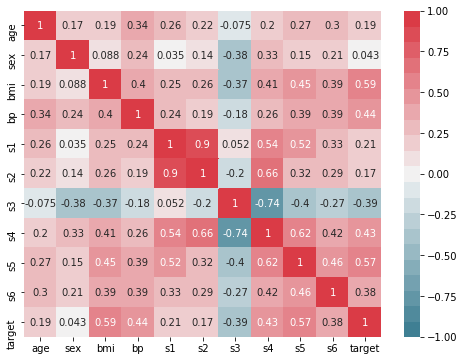

In [ ]:
X_diabetes, y_diabetes = sklearn.datasets.load_diabetes(return_X_y=True, as_frame=True)

inspector = get_inspector(
    RandomForestRegressor().fit(X_diabetes, y_diabetes), X_diabetes, y_diabetes
)

_, ax = plt.subplots(figsize=(8, 6))
ax = inspector.plot_correlation(ax=ax)

## Regressors

All regression model `Inspectors` have the following methods.

In [ ]:
from model_inspector.inspect import _RegInspector

show_doc(_RegInspector.plot_pred_vs_act, title_level=3)

<h3 id="_RegInspector.plot_pred_vs_act" class="doc_header"><code>_RegInspector.plot_pred_vs_act</code><a href="https://github.com/gsganden/model_inspector/tree/master/model_inspector/inspect.py#L157" class="source_link" style="float:right">[source]</a></h3>

> <code>_RegInspector.plot_pred_vs_act</code>(**`ax`**:`Optional`\[`Axes`\]=*`None`*, **`scatter_kwargs`**:`Optional`\[`dict`\]=*`None`*, **`line_kwargs`**:`Optional`\[`dict`\]=*`None`*)

Plot predicted vs. actual values

Parameters:
- `ax`: Matplotlib `Axes` object. Plot will be added to this object
if provided; otherwise a new `Axes` object will be generated.
- `scatter_kwargs`: kwargs to pass to `plt.scatter`
- `line_kwargs`: kwargs to pass to `plt.plot`

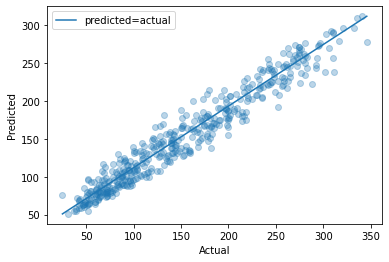

In [ ]:
ax = inspector.plot_pred_vs_act()

In [ ]:
from model_inspector.inspect import _RegInspector

show_doc(_RegInspector.plot_residuals, title_level=3)

<h3 id="_RegInspector.plot_residuals" class="doc_header"><code>_RegInspector.plot_residuals</code><a href="https://github.com/gsganden/model_inspector/tree/master/model_inspector/inspect.py#L194" class="source_link" style="float:right">[source]</a></h3>

> <code>_RegInspector.plot_residuals</code>(**`ax`**:`Optional`\[`Axes`\]=*`None`*, **`scatter_kwargs`**:`Optional`\[`dict`\]=*`None`*, **`line_kwargs`**:`Optional`\[`dict`\]=*`None`*)

Plot residuals

Parameters:
- `ax`: Matplotlib `Axes` object. Plot will be added to this object
if provided; otherwise a new `Axes` object will be generated.
- `scatter_kwargs`: kwargs to pass to `plt.scatter`
- `line_kwargs`: kwargs to pass to `plt.plot` for line at y=0

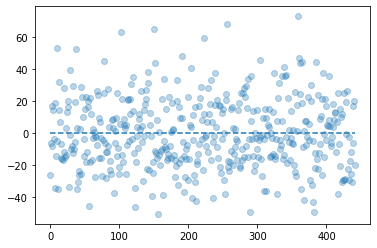

In [ ]:
ax = inspector.plot_residuals()

## Classifiers

Every `Inspector` object for a classification model has these methods.

In [ ]:
from model_inspector.inspect import _ClasInspector

show_doc(_ClasInspector.calculate_metrics_by_thresh, title_level=3)

<h3 id="_ClasInspector.calculate_metrics_by_thresh" class="doc_header"><code>_ClasInspector.calculate_metrics_by_thresh</code><a href="https://github.com/gsganden/model_inspector/tree/master/model_inspector/inspect.py#L128" class="source_link" style="float:right">[source]</a></h3>

> <code>_ClasInspector.calculate_metrics_by_thresh</code>(**`prob_to_pred`**:`Union`\[`str`, `Callable`\], **`metrics`**:`Union`\[`Callable`, `Sequence`\[`Callable`\]\])

Calculate classification metrics as a function of threshold

Parameters:
- `prob_to_pred`: Callable that takes
`self.model.predict_proba(self.X)` and `thresh` as positional
arguments and returns `y_pred`
- `metrics`: Callables that take `self.y`, `y_pred` as
positional arguments and return a number. Must have a `__name__`
attribute.

Returns: DataFrame with one column "thresh" indicating the
thresholds used, which is 0 and the sorted set of values that
occur in `y_prob`, and an additional column for each input
metric giving the value of that metric at that threshold.

/Users/gGandenberger/.pyenv/versions/model_inspector/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


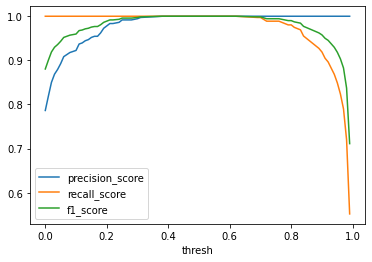

In [ ]:
X_cancer, y_cancer = sklearn.datasets.load_breast_cancer(return_X_y=True, as_frame=True)
inspector = get_inspector(
    RandomForestClassifier().fit(X_cancer, y_cancer), X_cancer, y_cancer
)


def predict_true_if_prob_above_thresh(y_prob, thresh):
    return np.where(y_prob[:, 1] > thresh, 1, 0)


ax = (
    inspector.calculate_metrics_by_thresh(
        prob_to_pred=predict_true_if_prob_above_thresh,
        metrics=[metrics.precision_score, metrics.recall_score, metrics.f1_score],
    )
    .iloc[:-1]
    .plot(x="thresh")
)

/Users/gGandenberger/.pyenv/versions/model_inspector/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


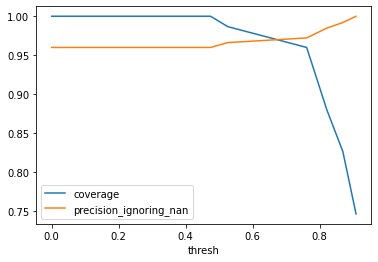

In [ ]:
precision_ignoring_nan = partial(
    calculate_metric_ignoring_nan,
    metric=partial(metrics.precision_score, average="micro"),
)
precision_ignoring_nan.__name__ = "precision_ignoring_nan"

X_iris, y_iris = sklearn.datasets.load_iris(return_X_y=True, as_frame=True)
inspector = get_inspector(
    RandomForestClassifier().fit(X_iris.iloc[:, [3]], y_iris),
    X_iris.iloc[:, [3]],
    y_iris,
)

ax = (
    inspector.calculate_metrics_by_thresh(
        prob_to_pred=lambda y_prob, thresh: np.where(
            y_prob.max(axis=1) > thresh, y_prob.argmax(axis=1), np.nan
        ),
        metrics=[coverage, precision_ignoring_nan],
    )
    .iloc[:-1]
    .plot(x="thresh")
)

## Linear Models

Every `Inspector` object for a linear model has these methods.

In [ ]:
from model_inspector.inspect import _LinRegInspector

show_doc(_LinRegInspector.show_equation, title_level=3)

<h3 id="_LinRegInspector.show_equation" class="doc_header"><code>_LinRegInspector.show_equation</code><a href="https://github.com/gsganden/model_inspector/tree/master/model_inspector/inspect.py#L321" class="source_link" style="float:right">[source]</a></h3>

> <code>_LinRegInspector.show_equation</code>(**`intercept_formatter`**:`str`=*`'.2f'`*, **`coef_formatter`**:`str`=*`'.2f'`*)

Show model equation

Parameters:
- `intercept_formatter`: Intercept format specifier
- `coef_formatter`: Intercept format specifier

In [ ]:
inspector = get_inspector(
    LinearRegression().fit(X_diabetes, y_diabetes), X_diabetes, y_diabetes
)

inspector.show_equation()

In [ ]:
inspector = get_inspector(
    LogisticRegression(max_iter=10_000).fit(X_cancer, y_cancer), X_cancer, y_cancer
)

inspector.show_equation()

In [ ]:
inspector = get_inspector(
    LogisticRegression(max_iter=10_000).fit(X_iris, y_iris), X_iris, y_iris
)

inspector.show_equation()

In [ ]:
from model_inspector.inspect import _LinRegInspector

show_doc(_LinRegInspector.plot_coefs_vs_hparam, title_level=3)

<h3 id="_LinRegInspector.plot_coefs_vs_hparam" class="doc_header"><code>_LinRegInspector.plot_coefs_vs_hparam</code><a href="https://github.com/gsganden/model_inspector/tree/master/model_inspector/inspect.py#L253" class="source_link" style="float:right">[source]</a></h3>

> <code>_LinRegInspector.plot_coefs_vs_hparam</code>(**`hparam`**:`str`, **`vals`**:`Sequence`\[`float`\])

Plot coefficient values against a hyperparameter

Parameters:
- `hparam`: Name of hyperparameter; must be an attribute of
`self.model`
- `vals`: Values of that hyperparameter to use

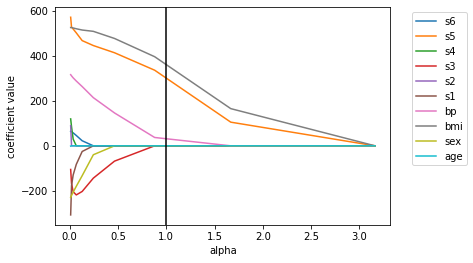

In [ ]:
inspector = get_inspector(Lasso().fit(X_diabetes, y_diabetes), X_diabetes, y_diabetes)

ax = inspector.plot_coefs_vs_hparam("alpha", np.logspace(-2, 0.5, 10))

This method is defined for linear regression and binary logistic regression models but not for multiclass logistic regression models.

In [ ]:
from model_inspector.inspect import _LinRegInspector

show_doc(_LinRegInspector.plot_waterfall, title_level=3)

<h3 id="_LinRegInspector.plot_waterfall" class="doc_header"><code>_LinRegInspector.plot_waterfall</code><a href="https://github.com/gsganden/model_inspector/tree/master/model_inspector/inspect.py#L280" class="source_link" style="float:right">[source]</a></h3>

> <code>_LinRegInspector.plot_waterfall</code>(**`item`**:`Union`\[`Series`, `array`\], **`bar_num_formatter`**:`str`=*`'.1f'`*, **`tick_num_formatter`**:`str`=*`'.2f'`*, **`sorted_value`**=*`True`*, **`threshold`**=*`0.01`*, **`blue_color`**=*`'#377eb8'`*, **`green_color`**=*`'#4daf4a'`*, **`red_color`**=*`'#ff7f00'`*, **\*\*`waterfall_kwargs`**)

Make a waterfall chart showing how each feature contributes
to the prediction for the input item.

Parameters:
- `item`: Input item, with the same shape and value meanings as
a single row from `self.X`
- `bar_num_formatter`: Bar label format specifier
- `tick_num_formatter`: Tick label format specifier

Additional keyword arguments will be passed to
`waterfall_chart.plot`

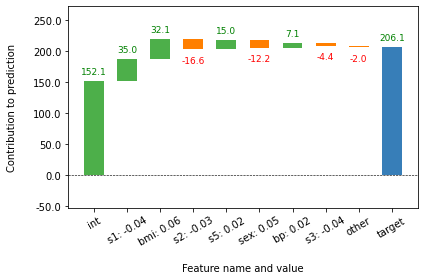

In [ ]:
inspector = get_inspector(
    LinearRegression().fit(X_diabetes, y_diabetes), X_diabetes, y_diabetes
)
ax = inspector.plot_waterfall(X_diabetes.iloc[0])

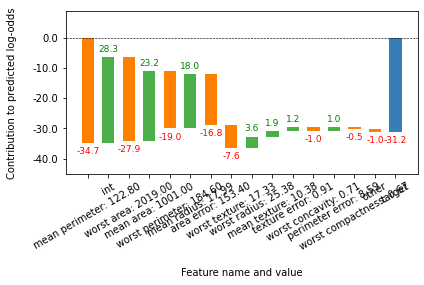

In [ ]:
inspector = get_inspector(
    LogisticRegression(max_iter=10_000).fit(X_cancer, y_cancer), X_cancer, y_cancer
)

ax = inspector.plot_waterfall(X_cancer.iloc[0])

## Models with One Feature

An `Inspector` for any model with one feature has a `plot` method. The interface is slightly different for binary models than for multiclass or regression models.

In [ ]:
from model_inspector.inspect import _Bin1dPlotter

show_doc(_Bin1dPlotter.plot, title_level=3)

<h3 id="_Bin1dPlotter.plot" class="doc_header"><code>_Bin1dPlotter.plot</code><a href="https://github.com/gsganden/model_inspector/tree/master/model_inspector/inspect.py#L627" class="source_link" style="float:right">[source]</a></h3>

> <code>_Bin1dPlotter.plot</code>(**`thresh`**:`Optional`\[`float`\]=*`0.5`*, **`plot_data`**:`bool`=*`True`*, **`prob_line_kwargs`**:`Optional`\[`dict`\]=*`None`*, **`thresh_line_kwargs`**:`Optional`\[`dict`\]=*`None`*, **`scatter_kwargs`**:`Optional`\[`dict`\]=*`None`*, **`ax`**:`Optional`\[`Axes`\]=*`None`*)

Plot predictions from a binary classification model that provides
probabilities and has a single input

Parameters:
- `thresh`: Threshold probability
- `plot_data`: Make a scatter plot of the data
- `prob_line_kwargs`: kwargs to pass to `ax.plot` for plotting
model probabilities
- `thresh_line_kwargs`: kwargs to pass to `ax.plot` for plotting
threshold
- `scatter_kwargs`: kwargs to pass to `ax.scatter` for plotting data
- `ax`: Matplotlib `Axes` object. Plot will be added to this object
if provided; otherwise a new `Axes` object will be generated.

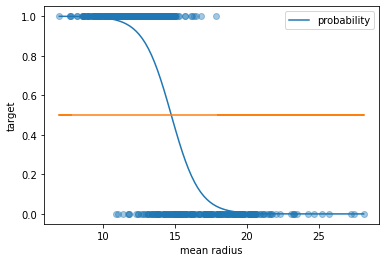

In [ ]:
inspector = get_inspector(
    LogisticRegression(max_iter=10_000).fit(X_cancer.iloc[:, [0]], y_cancer),
    X_cancer.iloc[:, [0]],
    y_cancer,
)

ax = inspector.plot()

In [ ]:
from model_inspector.inspect import _1dPlotter

show_doc(_1dPlotter.plot, title_level=3)

<h3 id="_1dPlotter.plot" class="doc_header"><code>_1dPlotter.plot</code><a href="https://github.com/gsganden/model_inspector/tree/master/model_inspector/inspect.py#L583" class="source_link" style="float:right">[source]</a></h3>

> <code>_1dPlotter.plot</code>(**`plot_data`**:`bool`=*`True`*, **`line_kwargs`**:`Optional`\[`dict`\]=*`None`*, **`scatter_kwargs`**:`Optional`\[`dict`\]=*`None`*, **`ax`**:`Optional`\[`Axes`\]=*`None`*)

Plot predictions from a regression or multiclass model with a
single input as a line

Parameters:
- `plot_data`: Make a scatter plot of the data
- `line_kwargs`: kwargs to pass to `ax.plot` for plotting
predictions
- `scatter_kwargs`: kwargs to pass to `ax.scatter` for plotting data
- `ax`: Matplotlib `Axes` object. Plot will be added to this object
if provided; otherwise a new `Axes` object will be generated.

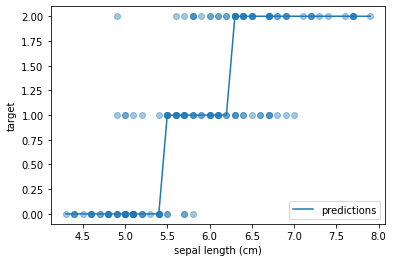

In [ ]:
inspector = get_inspector(
    LogisticRegression(max_iter=10_000).fit(X_iris.iloc[:, :1], y_iris),
    X_iris.iloc[:, :1],
    y_iris,
)

ax = inspector.plot()

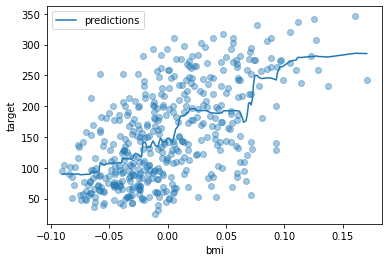

In [ ]:
inspector = get_inspector(
    RandomForestRegressor(max_depth=3).fit(X_diabetes.loc[:, ["bmi"]], y_diabetes),
    X_diabetes.loc[:, ["bmi"]],
    y_diabetes,
)

ax = inspector.plot()

## Models with Two Features

An `Inspector` for any model with two features also has a `plot` method.

In [ ]:
from model_inspector.inspect import _Clas2dPlotter

show_doc(_Clas2dPlotter.plot, title_level=3)

<h3 id="_Clas2dPlotter.plot" class="doc_header"><code>_Clas2dPlotter.plot</code><a href="https://github.com/gsganden/model_inspector/tree/master/model_inspector/inspect.py#L833" class="source_link" style="float:right">[source]</a></h3>

> <code>_Clas2dPlotter.plot</code>(**`plot_data`**:`bool`=*`True`*, **`heatmap_kwargs`**:`Optional`\[`dict`\]=*`None`*, **`scatter_kwargs`**:`Optional`\[`dict`\]=*`None`*, **`tick_formatter`**:`Optional`\[`str`\]=*`'.2f'`*, **`ax`**=*`None`*)

Plot data and predictions

Parameters:
- `plot_data`: Make a scatter plot of the data
- `heatmap_kwargs`: kwargs to pass to `sns.heatmap` for plotting
predictions
- `scatter_kwargs`: kwargs to pass to `ax.scatter` for plotting data
- `tick_formatter`: Tick label format specifier
- `ax`: Matplotlib `Axes` object. Plot will be added to this object
if provided; otherwise a new `Axes` object will be generated.

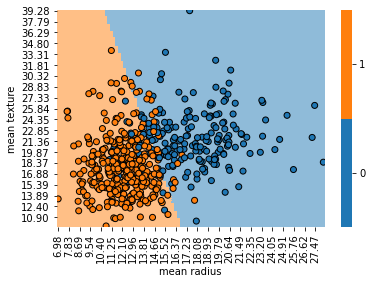

In [ ]:
inspector = get_inspector(
    LogisticRegression(max_iter=10_000).fit(X_cancer.iloc[:, :2], y_cancer),
    X_cancer.iloc[:, :2],
    y_cancer,
)

ax = inspector.plot()

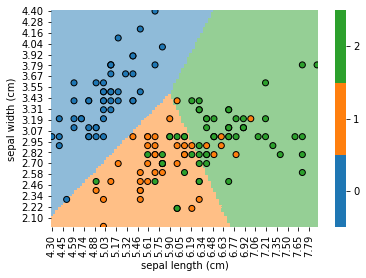

In [ ]:
inspector = get_inspector(
    LogisticRegression(max_iter=10_000).fit(X_iris.iloc[:, :2], y_iris),
    X_iris.iloc[:, :2],
    y_iris,
)

ax = inspector.plot()

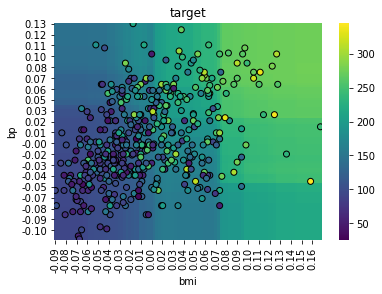

In [ ]:
inspector = get_inspector(
    RandomForestRegressor(max_depth=3).fit(
        X_diabetes.loc[:, ["bmi", "bp"]], y_diabetes
    ),
    X_diabetes.loc[:, ["bmi", "bp"]],
    y_diabetes,
)

ax = inspector.plot()

It also has a `plot3d` method. The interface is slightly different for binary models than for multiclass or regression models.

In [ ]:
from model_inspector.inspect import _Bin2dPlotter

show_doc(_Bin2dPlotter.plot3d, title_level=3)

<h3 id="_Bin2dPlotter.plot3d" class="doc_header"><code>_Bin2dPlotter.plot3d</code><a href="https://github.com/gsganden/model_inspector/tree/master/model_inspector/inspect.py#L915" class="source_link" style="float:right">[source]</a></h3>

> <code>_Bin2dPlotter.plot3d</code>(**`thresh`**=*`0.5`*, **`plot_prob`**:`bool`=*`True`*, **`plot_thresh`**:`bool`=*`True`*, **`plot_data`**:`bool`=*`True`*, **`prob_surf_kwargs`**:`Optional`\[`dict`\]=*`None`*, **`thresh_surf_kwargs`**:`Optional`\[`dict`\]=*`None`*, **`scatter_kwargs`**:`Optional`\[`dict`\]=*`None`*, **`ax`**=*`None`*)

Plot data and predictions in 3D

Best viewed with a tool such as https://github.com/matplotlib/ipympl
that supports rotating the output

Parameters:
- `thresh`: Probability threshold for counting a prediction as
positive
- `plot_prob`: Whether to plot the model probabilities
- `plot_thresh`: Whether to plot a classification threshold
- `plot_data`: Whether to plot the data
- `prob_surf_kwargs`: kwargs to pass to the model probability
surface
- `thresh_surf_kwargs`: kwargs to pass to the threshold surface
- `scatter_kwargs`: kwargs to pass to the scatter plot of the data
- `ax`: Matplotlib `Axes` object. Plot will be added to this object
if provided; otherwise a new `Axes` object will be generated.

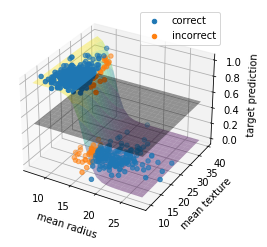

In [ ]:
inspector = get_inspector(
    LogisticRegression(max_iter=10_000).fit(X_cancer.iloc[:, :2], y_cancer),
    X_cancer.iloc[:, :2],
    y_cancer,
)

ax = inspector.plot3d()

An interactive tool such as [ipyml](https://github.com/matplotlib/ipympl) makes it easier to see depth in these 3D plots:

In [ ]:
from IPython.display import Video

Video(
    "https://github.com/gsganden/model_inspector/blob/master/docs/regression_3d.mov?raw=true"
)

In [ ]:
from model_inspector.inspect import _Reg2dPlotter

show_doc(_Reg2dPlotter.plot3d, title_level=3)

<h3 id="_Reg2dPlotter.plot3d" class="doc_header"><code>_Reg2dPlotter.plot3d</code><a href="https://github.com/gsganden/model_inspector/tree/master/model_inspector/inspect.py#L772" class="source_link" style="float:right">[source]</a></h3>

> <code>_Reg2dPlotter.plot3d</code>(**`plot_data`**:`bool`=*`True`*, **`surf_kwargs`**:`Optional`\[`dict`\]=*`None`*, **`scatter_kwargs`**:`Optional`\[`dict`\]=*`None`*, **`ax`**=*`None`*)

Plot data and predictions in 3d

Best viewed with a tool such as https://github.com/matplotlib/ipympl
that supports rotating the output

Parameters:
- `plot_data`: Make a scatter plot of the data
- `surf_kwargs`: kwargs to pass to `ax.plot_surface` for plotting
predictions
- `scatter_kwargs`: kwargs to pass to `ax.scatter` for plotting data
- `ax`: Matplotlib `Axes` object. Plot will be added to this object
if provided; otherwise a new `Axes` object will be generated.

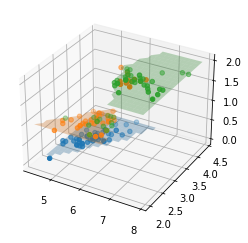

In [ ]:
inspector = get_inspector(
    LogisticRegression(max_iter=10_000).fit(X_iris.iloc[:, :2], y_iris),
    X_iris.iloc[:, :2],
    y_iris,
)

ax = inspector.plot3d()

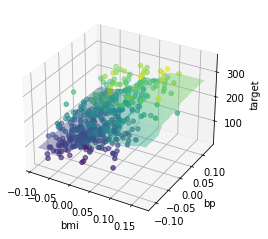

In [ ]:
inspector = get_inspector(
    RandomForestRegressor(max_depth=3).fit(
        X_diabetes.loc[:, ["bmi", "bp"]], y_diabetes
    ),
    X_diabetes.loc[:, ["bmi", "bp"]],
    y_diabetes,
)

ax = inspector.plot3d()